In [ ]:
!pip install imbalanced-learn


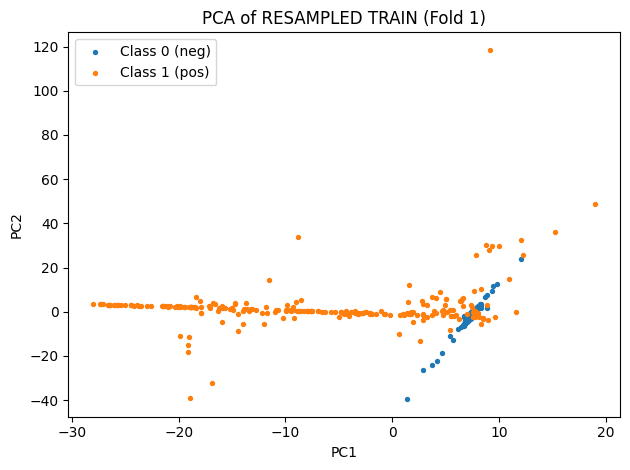

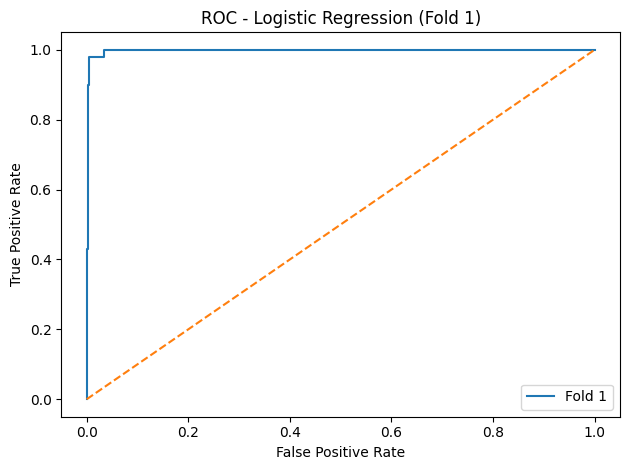

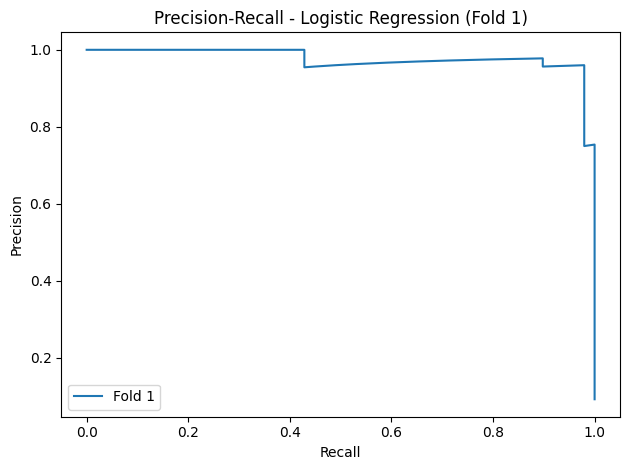

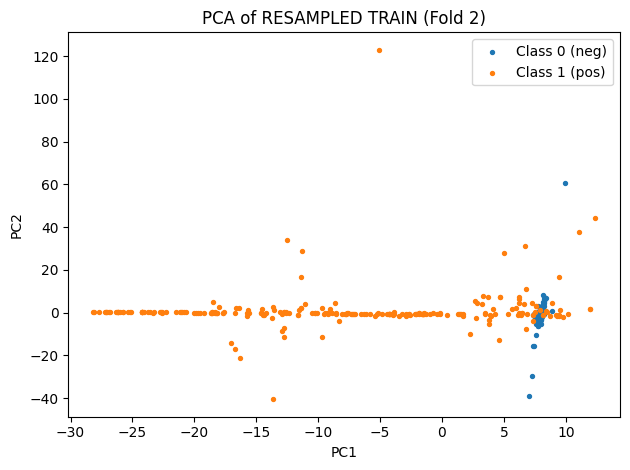

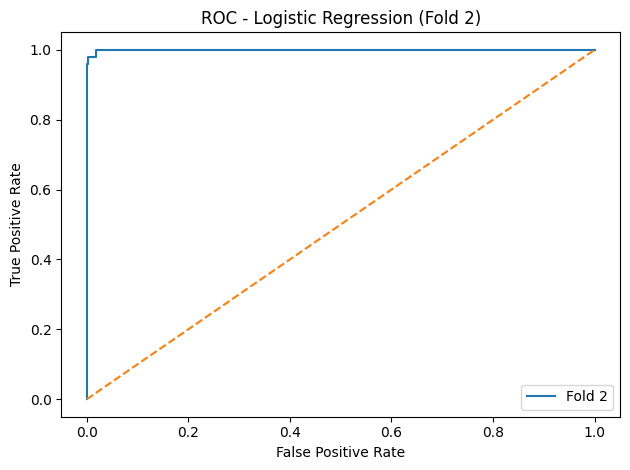

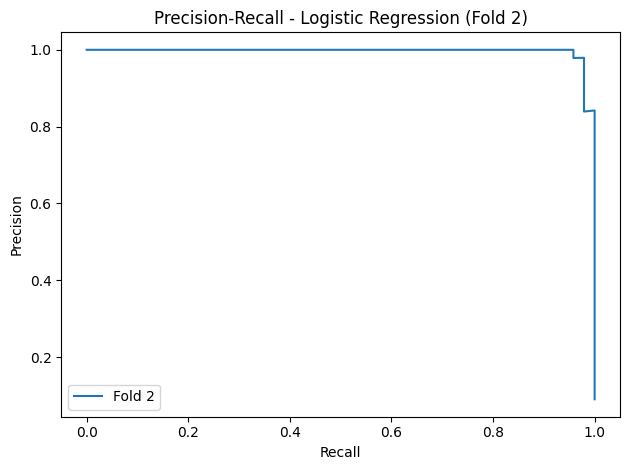

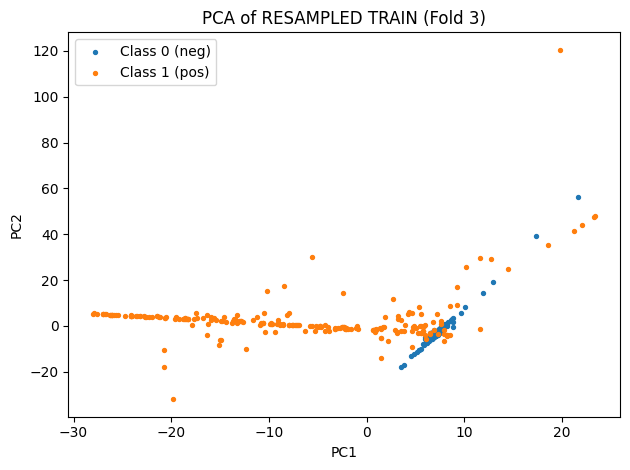

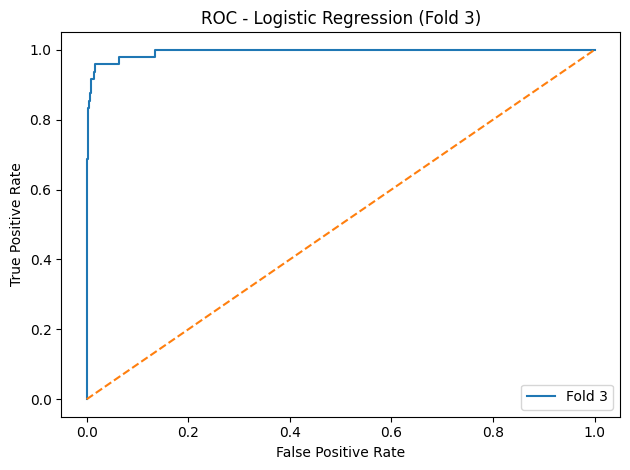

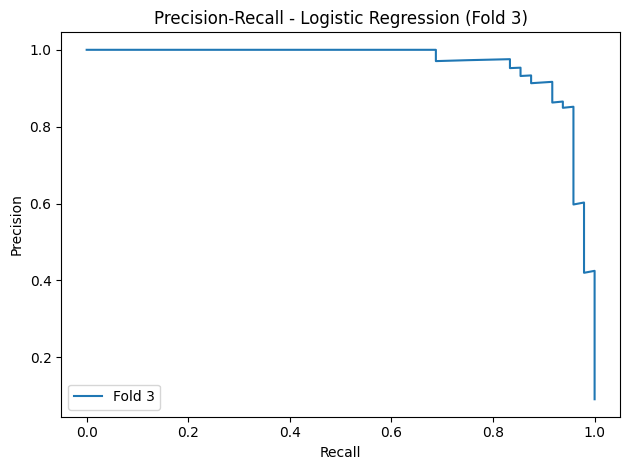

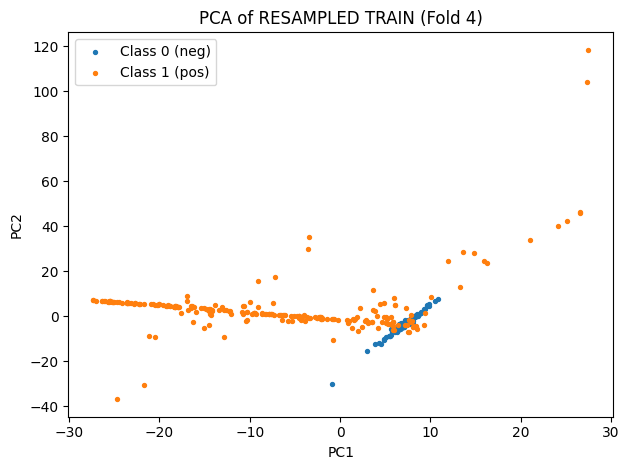

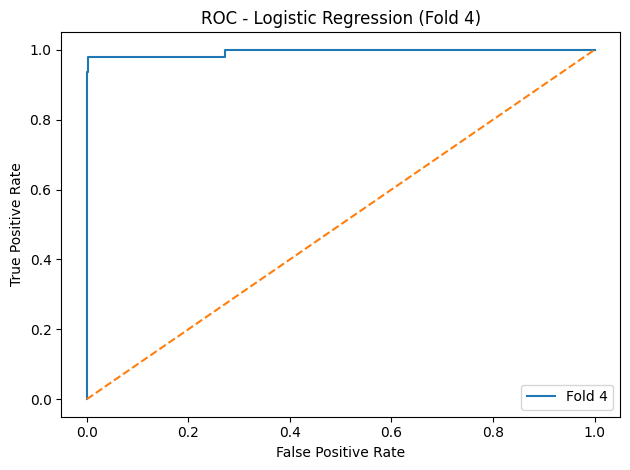

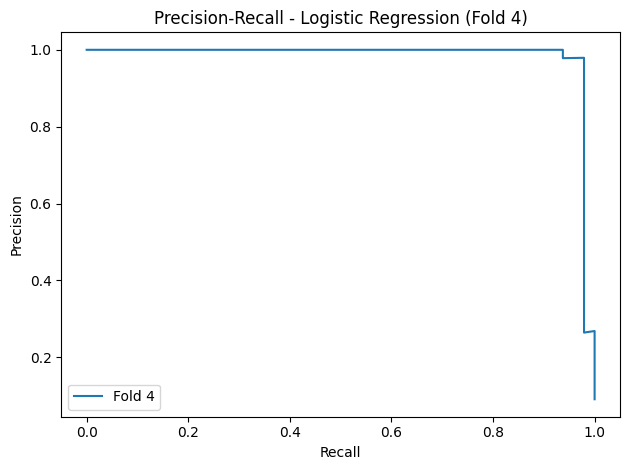

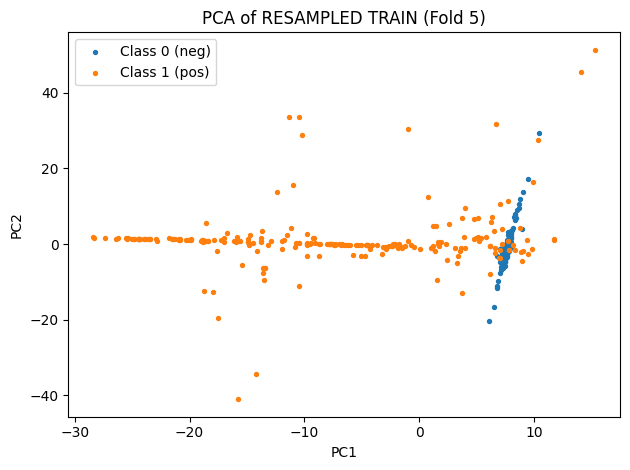

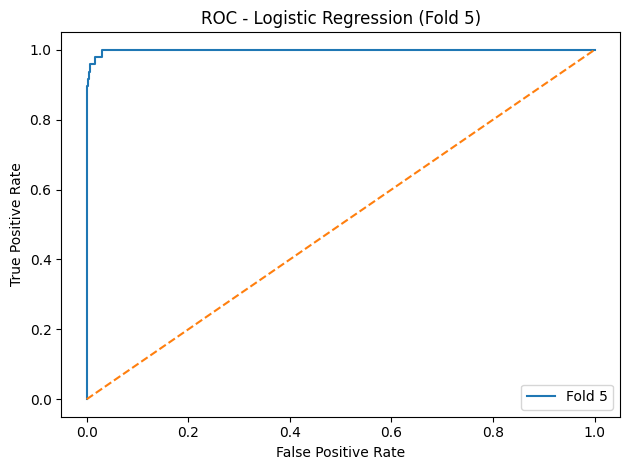

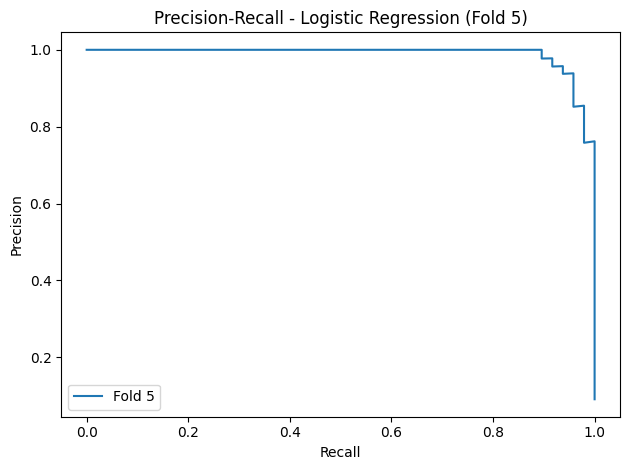


=== OOF Summary: Logistic Regression (Under→SMOTE 241/241, 5-fold) ===
ROC-AUC: 0.996705969011326
PR-AUC : 0.9794391564509052

Confusion matrix (0.5):
         Pred 0  Pred 1
True 0    2387      24
True 1      10     231

Classification report (0.5):
               precision    recall  f1-score   support

           0      0.996     0.990     0.993      2411
           1      0.906     0.959     0.931       241

    accuracy                          0.987      2652
   macro avg      0.951     0.974     0.962      2652
weighted avg      0.988     0.987     0.987      2652



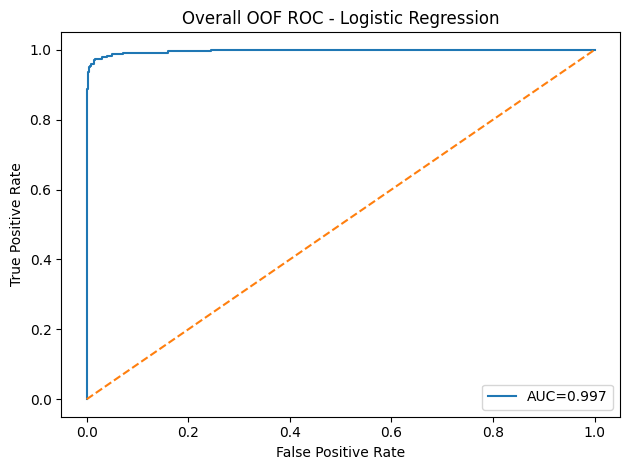

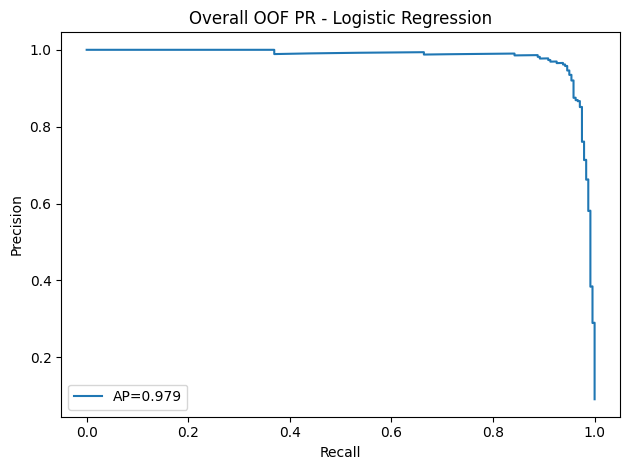


Top predictors by mean |coef| across folds (Logistic Regression):

                                          feature  mean_coef  std_coef  mean_abs  mean_odds_ratio
                            num_plain__Unnamed: 0  -3.120149  0.525668  3.120149         0.044151
                  cat__Lake_type_simplified_other  -1.490424  0.244232  1.490424         0.225277
   num_plain__missingindicator_10y_expansion_rate   0.874185  0.142831  0.874185         2.396922
                           num_plain__Elevation_m  -0.741560  0.159732  0.741560         0.476370
                             num_plain__Longitude   0.668932  0.335339  0.668932         1.952151
                              num_plain__Latitude   0.666086  0.065851  0.666086         1.946603
                       num_plain__is_supraglacial   0.613862  0.291825  0.613862         1.847553
                 num_log__Lake_area_calculated_ha  -0.595075  0.225027  0.595075         0.551521
                  num_log__nearest_glacier_dist_m 

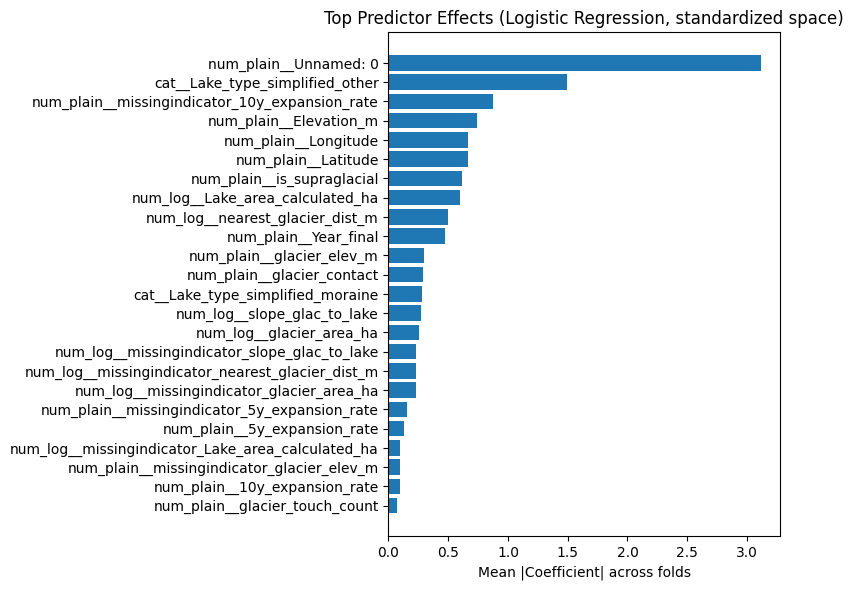

In [9]:
# === Logistic Regression ONLY: full pipeline with CV, SMOTE(241), visuals, and feature effects ===
# - Missing data: SimpleImputer (num=median+indicator, cat=most_frequent)
# - Categorical: OneHotEncoder(drop='first', handle_unknown='ignore')
# - Outliers: log1p for non-negative heavy-tailed; Robust/Standard scaling elsewhere
# - Per fold: RandomUnderSampler({0:241}) -> SMOTE({1:241}) on TRAIN only (no leakage)
# - Visuals: per-fold PCA of resampled TRAIN, per-fold ROC/PR; OOF ROC/PR + confusion matrices
# - Effects: per-fold LR coefficients mapped to features; aggregate mean +/- std and odds ratios

# !pip install imbalanced-learn  # <--- uncomment and run once if imblearn isn't available

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# --------------------------- Load data ---------------------------
CSV_PATH = "uncleaned_ml_combined.csv"    # adjust if needed
if not Path(CSV_PATH).exists():
    raise FileNotFoundError(f"Could not find: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
if "GLOF" not in df.columns:
    raise ValueError("Expected a 'GLOF' column in the CSV.")

X = df.drop(columns=["GLOF"])
y = df["GLOF"].astype(int)

# --------------------------- Columns ---------------------------
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()   # e.g., ["Lake_type_simplified"]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# non-negative heavy-tailed -> log1p (adjust list to your schema)
log1p_candidates = ["Lake_area_calculated_ha","glacier_area_ha","slope_glac_to_lake","nearest_glacier_dist_m"]
log1p_cols = [c for c in log1p_candidates if c in num_cols and X[c].min(skipna=True) >= 0]
num_plain_cols = [c for c in num_cols if c not in set(log1p_cols)]

# --------------------------- Preprocessing ---------------------------
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

num_log_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scale", StandardScaler()),
])

num_plain_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", RobustScaler()),   # robust to outliers/heavy tails
])

preprocessor = ColumnTransformer([
    ("cat",       cat_pipe,      cat_cols),
    ("num_log",   num_log_pipe,  log1p_cols),
    ("num_plain", num_plain_pipe,num_plain_cols),
])

# Make dense for SMOTE (OHE may output sparse)
to_dense = FunctionTransformer(lambda A: A.toarray() if hasattr(A, "toarray") else A, accept_sparse=True)

# --------------------------- Samplers (per fold) ---------------------------
undersample = RandomUnderSampler(sampling_strategy={0: 241}, random_state=42)  # first trim majority class (negatives)
smote       = SMOTE(sampling_strategy={1: 241}, random_state=42, k_neighbors=5)  # then synthesize positives to 241

# --------------------------- Model (LR only) ---------------------------
lr_model = LogisticRegression(max_iter=2000, solver="lbfgs")  # no class_weight; we explicitly balance via samplers

pipe_lr = ImbPipeline([
    ("prep", preprocessor),
    ("dense", to_dense),
    ("under", undersample),
    ("smote", smote),
    ("clf", lr_model),
])

# --------------------------- CV scaffold ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba = np.zeros(len(X), dtype=float)
oof_true  = y.values.copy()

# store coefficients per fold (mapped to feature names)
coef_tables = []

fold_idx = 1
for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # ---- Visualize TRAIN POINTS (resampled) with PCA ----
    # Fit preprocessor on TRAIN, then resample explicitly to plot the actual train points used for LR
    Xt = preprocessor.fit_transform(X_tr)
    Xt = to_dense.transform(Xt)
    Xt_u, yt_u = undersample.fit_resample(Xt, y_tr)
    Xt_rs, yt_rs = smote.fit_resample(Xt_u, yt_u)

    pca = PCA(n_components=2, random_state=42)
    XY = pca.fit_transform(Xt_rs)

    plt.figure()
    plt.scatter(XY[yt_rs==0, 0], XY[yt_rs==0, 1], s=8, label="Class 0 (neg)")
    plt.scatter(XY[yt_rs==1, 0], XY[yt_rs==1, 1], s=8, label="Class 1 (pos)")
    plt.title(f"PCA of RESAMPLED TRAIN (Fold {fold_idx})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Fit LR pipeline on this fold ----
    pipe_lr.fit(X_tr, y_tr)

    # ---- Per-fold coefficients mapped to features ----
    feat_names = pipe_lr.named_steps["prep"].get_feature_names_out()
    coefs = pipe_lr.named_steps["clf"].coef_[0]
    coef_df = pd.DataFrame({
        "feature": feat_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "odds_ratio": np.exp(coefs)  # effect on odds per +1 standardized unit / one-hot step
    }).sort_values("abs_coef", ascending=False)
    coef_df["fold"] = fold_idx
    coef_tables.append(coef_df)

    # ---- OOF predictions on validation fold ----
    proba = pipe_lr.predict_proba(X_te)[:, 1]
    oof_proba[test_idx] = proba

    # ---- Per-fold ROC & PR plots ----
    fpr, tpr, _ = roc_curve(y_te, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold_idx}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC - Logistic Regression (Fold {fold_idx})")
    plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

    pr, rc, _ = precision_recall_curve(y_te, proba)
    plt.figure()
    plt.plot(rc, pr, label=f"Fold {fold_idx}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall - Logistic Regression (Fold {fold_idx})")
    plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

    fold_idx += 1

# --------------------------- Aggregate OOF metrics & plots ---------------------------
roc = roc_auc_score(oof_true, oof_proba)
pr  = average_precision_score(oof_true, oof_proba)
print(f"\n=== OOF Summary: Logistic Regression (Under→SMOTE 241/241, 5-fold) ===")
print("ROC-AUC:", roc)
print("PR-AUC :", pr)

# Default 0.5 threshold for summary
oof_pred = (oof_proba >= 0.5).astype(int)
print("\nConfusion matrix (0.5):\n", pd.DataFrame(
    confusion_matrix(oof_true, oof_pred),
    index=["True 0","True 1"], columns=["Pred 0","Pred 1"]
))
print("\nClassification report (0.5):\n", classification_report(oof_true, oof_pred, digits=3))

# Overall ROC & PR plots
fpr, tpr, _ = roc_curve(oof_true, oof_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Overall OOF ROC - Logistic Regression")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

prc, rcl, _ = precision_recall_curve(oof_true, oof_proba)
plt.figure()
plt.plot(rcl, prc, label=f"AP={pr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Overall OOF PR - Logistic Regression")
plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

# --------------------------- Aggregate predictor effects across folds ---------------------------
coef_all = pd.concat(coef_tables, ignore_index=True)

# Mean effect across folds
agg = (coef_all
       .groupby("feature", as_index=False)
       .agg(mean_coef=("coef","mean"),
            std_coef=("coef","std"),
            mean_abs=("abs_coef","mean"))
       .sort_values("mean_abs", ascending=False))

# odds ratio corresponding to mean_coef
agg["mean_odds_ratio"] = np.exp(agg["mean_coef"])

# Show top 25 by mean_abs effect
top_k = 25
print("\nTop predictors by mean |coef| across folds (Logistic Regression):\n")
print(agg.head(top_k)[["feature","mean_coef","std_coef","mean_abs","mean_odds_ratio"]]
      .to_string(index=False))

# Optional: bar plot of top effects by |coef|
plt.figure(figsize=(8, 6))
top = agg.head(top_k)
plt.barh(top["feature"][::-1], top["mean_abs"][::-1])
plt.xlabel("Mean |Coefficient| across folds")
plt.title("Top Predictor Effects (Logistic Regression, standardized space)")
plt.tight_layout(); plt.show()



=== Fold 1 Metrics (Balanced RF) ===
ROC-AUC: 1.0000 | PR-AUC: 1.0000 | Accuracy: 1.0000
Confusion matrix (0.5):
         Pred 0  Pred 1
True 0     482       0
True 1       0      49

Classification report (0.5):
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       482
           1      1.000     1.000     1.000        49

    accuracy                          1.000       531
   macro avg      1.000     1.000     1.000       531
weighted avg      1.000     1.000     1.000       531



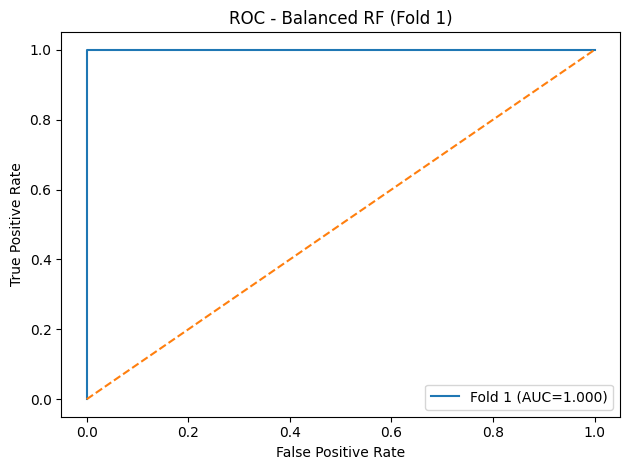

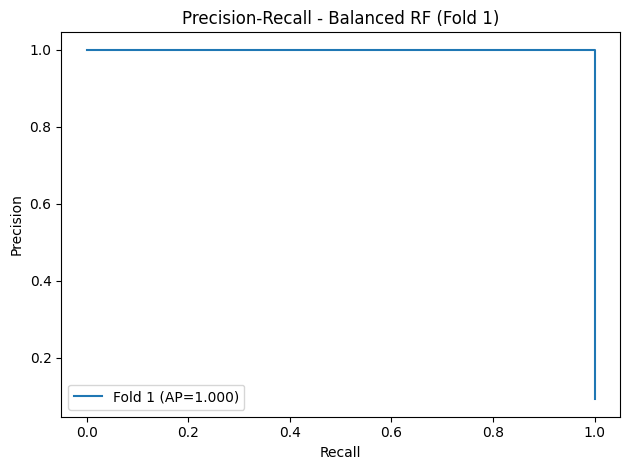


=== Fold 2 Metrics (Balanced RF) ===
ROC-AUC: 0.9999 | PR-AUC: 0.9992 | Accuracy: 0.9944
Confusion matrix (0.5):
         Pred 0  Pred 1
True 0     480       3
True 1       0      48

Classification report (0.5):
               precision    recall  f1-score   support

           0      1.000     0.994     0.997       483
           1      0.941     1.000     0.970        48

    accuracy                          0.994       531
   macro avg      0.971     0.997     0.983       531
weighted avg      0.995     0.994     0.994       531



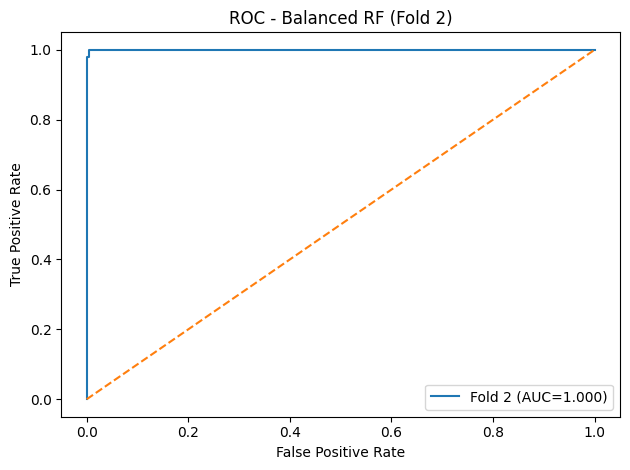

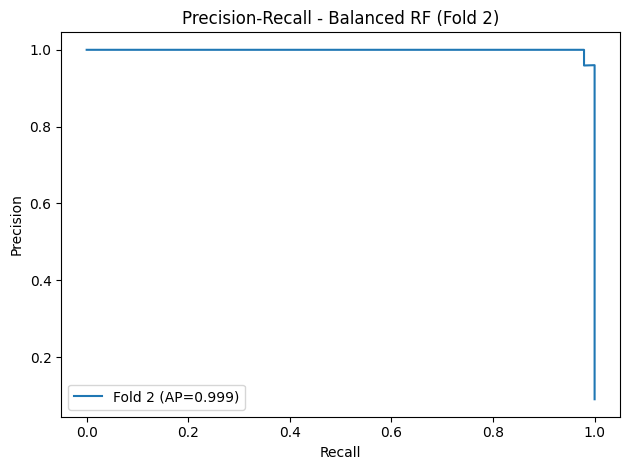


=== Fold 3 Metrics (Balanced RF) ===
ROC-AUC: 0.9938 | PR-AUC: 0.9637 | Accuracy: 0.9868
Confusion matrix (0.5):
         Pred 0  Pred 1
True 0     479       3
True 1       4      44

Classification report (0.5):
               precision    recall  f1-score   support

           0      0.992     0.994     0.993       482
           1      0.936     0.917     0.926        48

    accuracy                          0.987       530
   macro avg      0.964     0.955     0.960       530
weighted avg      0.987     0.987     0.987       530



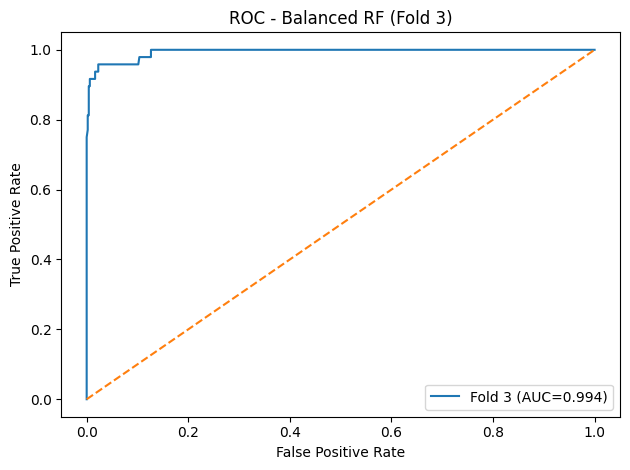

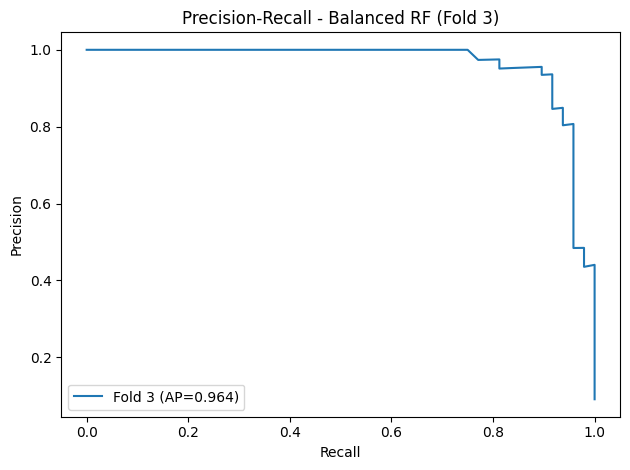


=== Fold 4 Metrics (Balanced RF) ===
ROC-AUC: 0.9994 | PR-AUC: 0.9951 | Accuracy: 0.9925
Confusion matrix (0.5):
         Pred 0  Pred 1
True 0     479       3
True 1       1      47

Classification report (0.5):
               precision    recall  f1-score   support

           0      0.998     0.994     0.996       482
           1      0.940     0.979     0.959        48

    accuracy                          0.992       530
   macro avg      0.969     0.986     0.978       530
weighted avg      0.993     0.992     0.993       530



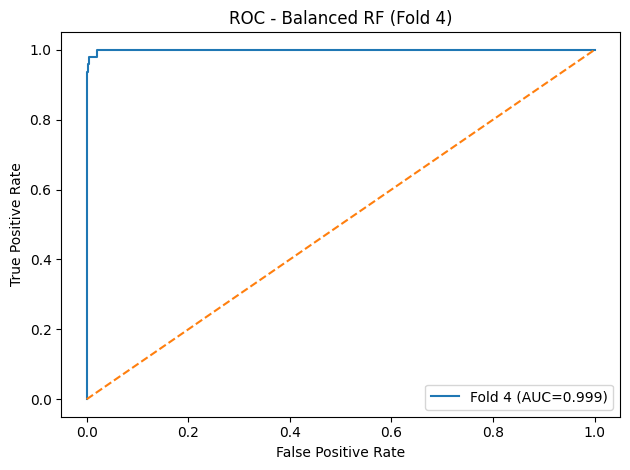

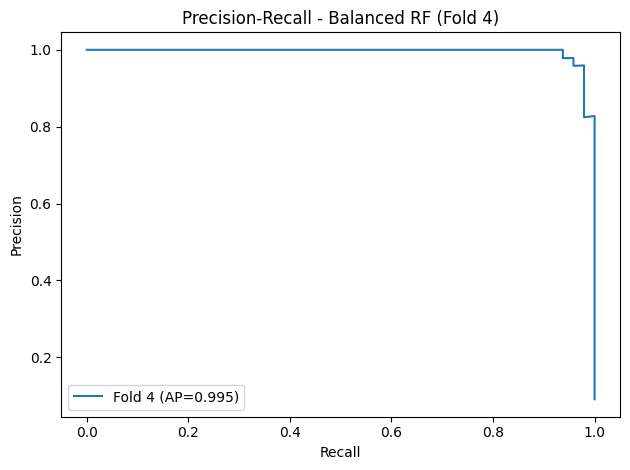


=== Fold 5 Metrics (Balanced RF) ===
ROC-AUC: 0.9995 | PR-AUC: 0.9953 | Accuracy: 0.9925
Confusion matrix (0.5):
         Pred 0  Pred 1
True 0     478       4
True 1       0      48

Classification report (0.5):
               precision    recall  f1-score   support

           0      1.000     0.992     0.996       482
           1      0.923     1.000     0.960        48

    accuracy                          0.992       530
   macro avg      0.962     0.996     0.978       530
weighted avg      0.993     0.992     0.993       530



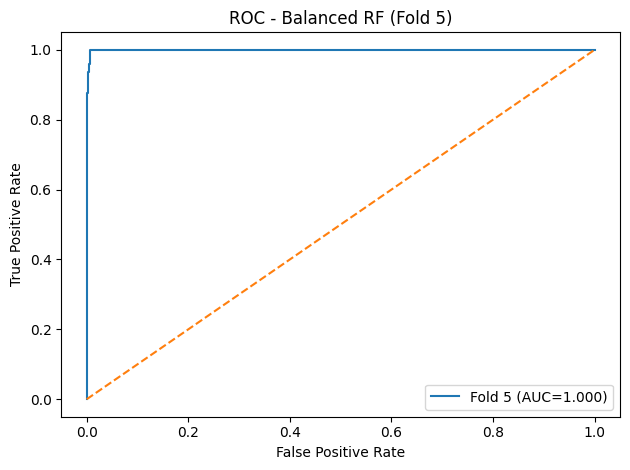

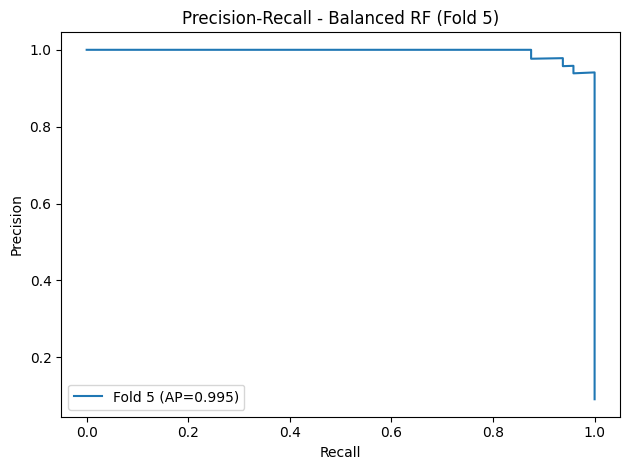


=== OOF Summary: Balanced RF (5-fold) ===
ROC-AUC: 0.9982850042423126
PR-AUC : 0.9904468016335366

OOF Confusion matrix (0.5):
         Pred 0  Pred 1
True 0    2398      13
True 1       5     236

OOF Classification report (0.5):
               precision    recall  f1-score   support

           0      0.998     0.995     0.996      2411
           1      0.948     0.979     0.963       241

    accuracy                          0.993      2652
   macro avg      0.973     0.987     0.980      2652
weighted avg      0.993     0.993     0.993      2652



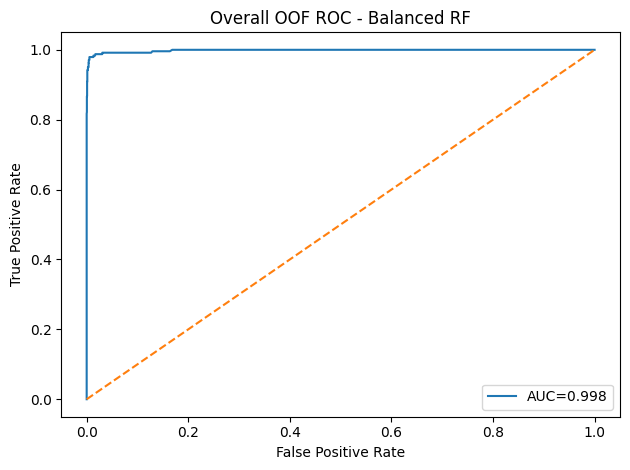

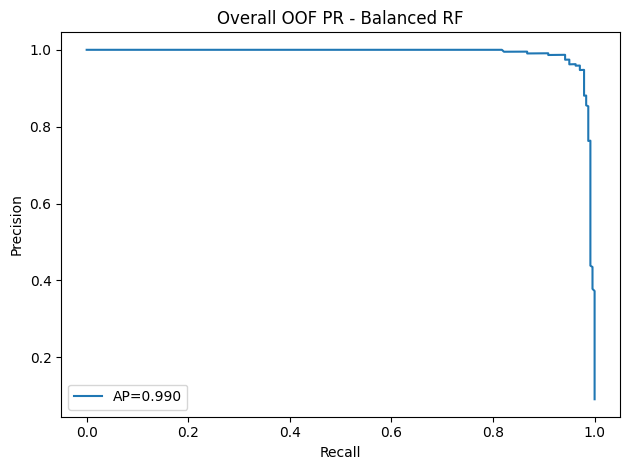


Top features by mean importance across folds (Balanced RF):

                                          feature  mean_importance  std_importance
                            num_plain__Year_final         0.305741        0.008697
                              num_plain__Latitude         0.140177        0.008002
                             num_plain__Longitude         0.092010        0.008234
   num_plain__missingindicator_10y_expansion_rate         0.075616        0.005278
                  cat__Lake_type_simplified_other         0.062212        0.007054
                           num_plain__Elevation_m         0.059052        0.004298
                         num_log__glacier_area_ha         0.045743        0.001189
    num_plain__missingindicator_5y_expansion_rate         0.044664        0.006956
                        num_plain__glacier_elev_m         0.024511        0.002226
                 num_log__Lake_area_calculated_ha         0.024049        0.001681
                     num_

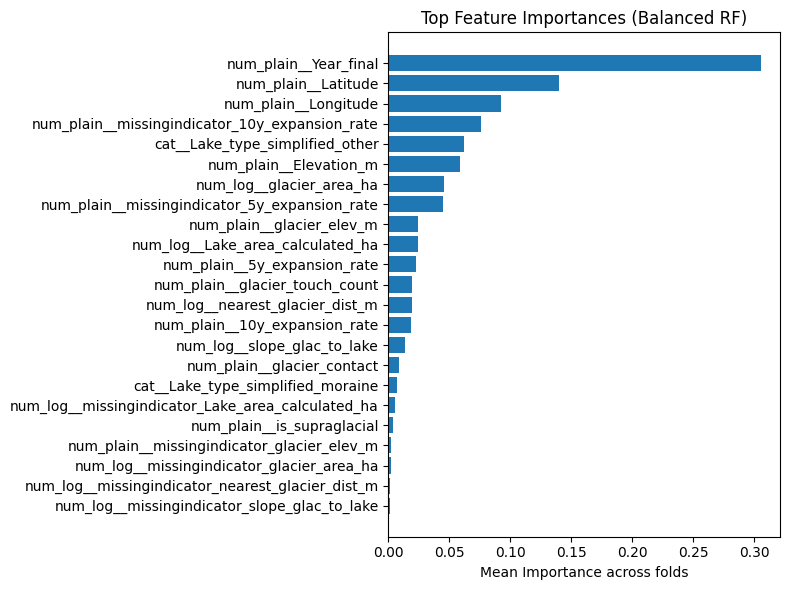


Per-fold metrics table:
  fold  roc_auc   pr_auc  accuracy  tn  fp  fn  tp
    1 1.000000 1.000000  1.000000 482   0   0  49
    2 0.999914 0.999167  0.994350 480   3   0  48
    3 0.993819 0.963670  0.986792 479   3   4  44
    4 0.999438 0.995114  0.992453 479   3   1  47
    5 0.999525 0.995277  0.992453 478   4   0  48


In [14]:
# === Balanced Random Forest: full pipeline with CV, per-fold test metrics, visuals, and feature importances ===
# - Missing data: SimpleImputer (num=median+indicator, cat=most_frequent)
# - Categorical: OneHotEncoder(drop='first', handle_unknown='ignore')
# - Outliers: log1p for non-negative heavy-tailed; Robust/Standard scaling elsewhere (OK for trees too)
# - Model: imblearn.ensemble.BalancedRandomForestClassifier (auto class-balancing per tree)
# - CV: 5-fold stratified, metrics per fold on the hold-out fold only (no leakage)
# - Visuals: per-fold ROC/PR; OOF ROC/PR; top feature importances aggregated

# !pip install imbalanced-learn  # <--- if not already installed

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, accuracy_score
)

from imblearn.ensemble import BalancedRandomForestClassifier

# --------------------------- Load data ---------------------------
CSV_PATH = "uncleaned_ml_combined.csv"    # adjust if needed
if not Path(CSV_PATH).exists():
    raise FileNotFoundError(f"Could not find: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
if "GLOF" not in df.columns:
    raise ValueError("Expected a 'GLOF' column in the CSV.")

X = df.drop(columns=["GLOF"])
y = df["GLOF"].astype(int)

# --------------------------- Columns ---------------------------
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# non-negative heavy-tailed -> log1p (adjust list to your schema)
log1p_candidates = ["Lake_area_calculated_ha","glacier_area_ha","slope_glac_to_lake","nearest_glacier_dist_m"]
log1p_cols = [c for c in log1p_candidates if c in num_cols and X[c].min(skipna=True) >= 0]
num_plain_cols = [c for c in num_cols if c not in set(log1p_cols)]

# --------------------------- Preprocessing ---------------------------
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

num_log_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scale", StandardScaler()),
])

num_plain_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale", RobustScaler()),
])

preprocessor = ColumnTransformer([
    ("cat",       cat_pipe,      cat_cols),
    ("num_log",   num_log_pipe,  log1p_cols),
    ("num_plain", num_plain_pipe,num_plain_cols),
])

# Make dense in case OHE is sparse (safe for ~thousands of rows)
to_dense = FunctionTransformer(lambda A: A.toarray() if hasattr(A, "toarray") else A, accept_sparse=True)

# --------------------------- Model (Balanced RF) ---------------------------
brf_model = BalancedRandomForestClassifier(
    n_estimators=500,          # bump trees for stability
    max_depth=None,            # let trees grow; you can tune (e.g., 8-20)
    min_samples_leaf=1,
    sampling_strategy="auto",  # balance each bootstrap sample
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

pipe_brf = Pipeline([
    ("prep", preprocessor),
    ("dense", to_dense),
    ("clf", brf_model),
])

# --------------------------- CV scaffold ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba = np.zeros(len(X), dtype=float)
oof_true  = y.values.copy()

# per-fold metrics table + per-fold feature importances
fold_metrics = []
fi_tables = []

fold_idx = 1
for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # ---- Fit BRF pipeline on TRAIN ----
    pipe_brf.fit(X_tr, y_tr)

    # ---- Predict on TEST fold ----
    proba = pipe_brf.predict_proba(X_te)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    # ---- Metrics on TEST fold ----
    roc  = roc_auc_score(y_te, proba)
    pr   = average_precision_score(y_te, proba)
    acc  = accuracy_score(y_te, pred)
    cm   = confusion_matrix(y_te, pred)

    print(f"\n=== Fold {fold_idx} Metrics (Balanced RF) ===")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | Accuracy: {acc:.4f}")
    print("Confusion matrix (0.5):\n", pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
    print("\nClassification report (0.5):\n", classification_report(y_te, pred, digits=3))

    # store per-fold metrics
    fold_metrics.append({
        "fold": fold_idx, "roc_auc": roc, "pr_auc": pr, "accuracy": acc,
        "tn": cm[0,0], "fp": cm[0,1], "fn": cm[1,0], "tp": cm[1,1]
    })

    # ---- Per-fold ROC & PR plots ----
    fpr, tpr, _ = roc_curve(y_te, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold_idx} (AUC={roc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC - Balanced RF (Fold {fold_idx})")
    plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

    prc, rcl, _ = precision_recall_curve(y_te, proba)
    plt.figure()
    plt.plot(rcl, prc, label=f"Fold {fold_idx} (AP={pr:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall - Balanced RF (Fold {fold_idx})")
    plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

    # ---- Save OOF for global plots ----
    oof_proba[test_idx] = proba

    # ---- Per-fold feature importances mapped to features ----
    feat_names = pipe_brf.named_steps["prep"].get_feature_names_out()
    importances = pipe_brf.named_steps["clf"].feature_importances_
    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi_df["fold"] = fold_idx
    fi_tables.append(fi_df.sort_values("importance", ascending=False))

    fold_idx += 1

# --------------------------- Aggregate OOF metrics & plots ---------------------------
roc_oof = roc_auc_score(oof_true, oof_proba)
pr_oof  = average_precision_score(oof_true, oof_proba)
print(f"\n=== OOF Summary: Balanced RF (5-fold) ===")
print("ROC-AUC:", roc_oof)
print("PR-AUC :", pr_oof)

# Default 0.5 threshold for OOF summary
oof_pred = (oof_proba >= 0.5).astype(int)
print("\nOOF Confusion matrix (0.5):\n", pd.DataFrame(
    confusion_matrix(oof_true, oof_pred),
    index=["True 0","True 1"], columns=["Pred 0","Pred 1"]
))
print("\nOOF Classification report (0.5):\n", classification_report(oof_true, oof_pred, digits=3))

# Overall ROC & PR plots
fpr, tpr, _ = roc_curve(oof_true, oof_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_oof:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Overall OOF ROC - Balanced RF")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

prc, rcl, _ = precision_recall_curve(oof_true, oof_proba)
plt.figure()
plt.plot(rcl, prc, label=f"AP={pr_oof:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Overall OOF PR - Balanced RF")
plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

# --------------------------- Aggregate feature importances across folds ---------------------------
fi_all = pd.concat(fi_tables, ignore_index=True)
fi_agg = (fi_all
          .groupby("feature", as_index=False)
          .agg(mean_importance=("importance","mean"),
               std_importance=("importance","std"))
          .sort_values("mean_importance", ascending=False))

top_k = 25
print("\nTop features by mean importance across folds (Balanced RF):\n")
print(fi_agg.head(top_k).to_string(index=False))

# Optional: bar plot of top importances
plt.figure(figsize=(8, 6))
top = fi_agg.head(top_k)
plt.barh(top["feature"][::-1], top["mean_importance"][::-1])
plt.xlabel("Mean Importance across folds")
plt.title("Top Feature Importances (Balanced RF)")
plt.tight_layout(); plt.show()

# --------------------------- (Optional) save per-fold metrics table ---------------------------
metrics_df = pd.DataFrame(fold_metrics)
print("\nPer-fold metrics table:\n", metrics_df.to_string(index=False))
# metrics_df.to_csv("brf_per_fold_metrics.csv", index=False)
